# MIO PROJEKT 2 - SIECI KOHONENA

In [11]:
import plotly.graph_objects as go
from SOM import *
import seaborn as sns
from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score, confusion_matrix,f1_score
from scipy.optimize import linear_sum_assignment
import warnings

In [12]:
def get_scores(som,X,y):
    y_pred  = som.find_clusters(X)
    h_score = homogeneity_score(y, y_pred)
    c_score = completeness_score(y, y_pred)
    v_score = v_measure_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)

    # Apply the Hungarian algorithm to find the optimal matching between the predicted and true labels
    row_ind, col_ind = linear_sum_assignment(-conf_matrix)


    y_pred_relabeled = np.zeros_like(y_pred)
    for i, j in zip(col_ind, range(len(y_pred))):
        y_pred_relabeled[y_pred == i] = j
    
    f1 = f1_score(y, y_pred_relabeled, average='macro')
    
    return y_pred_relabeled, y_pred,f1, h_score,c_score,v_score


def coefs_search(X,y, input_dim, map_size, epochs, neighborhood_functions, learning_rates, sigmas, decays,allow_warnings=False, debug=False):
    warnings.filterwarnings("error") if not allow_warnings else warnings.filterwarnings("ignore")
    for neighborhood_function in neighborhood_functions:
        for learning_rate in learning_rates:
            for sigma in sigmas:
                for decay in decays:
                    som = SOM(input_dim=input_dim, map_size=map_size)
                    try:
                        som.train(X, epochs=epochs, neighborhood_function=neighborhood_function, learning_rate=learning_rate, sigma=sigma, learning_rate_decay=decay)
                    except Exception as e:
                        if debug:
                            print(e)
                        print(f"Error with parameters: {neighborhood_function=}, {learning_rate=}, {sigma=}, {decay=}")
                    else: 
                        y_pred_relabeled, y_pred,f1, h_score,c_score,v_score = get_scores(som,X,y)
                        print(f"{v_score=} | function={neighborhood_function.__name__}, {learning_rate=}, {sigma=}, {decay=}")
                    
    warnings.filterwarnings("default")




def plot_clusters_2D(som,df):

    y_pred_relabeled, y_pred, f1, h_score,c_score,v_score = get_scores(som,df[['x','y']].values,df['c'])

    errors = df["c"] != y_pred_relabeled
    y_pred = pd.Series(y_pred)

    palette = sns.color_palette("deep", as_cmap=True, n_colors=len(som.weights))
    all_labels = sorted(set(df["c"]))
    color_map = dict(zip(all_labels, palette))



    fig = plt.figure(figsize=(10,10))
    sns.scatterplot(data=df, x="x", y="y", hue=df["c"], palette=color_map, s=50)
    sns.scatterplot(x=df.loc[errors,"x"],y= df.loc[errors,"y"], hue=y_pred_relabeled[errors], palette=color_map, marker="x", s=100, legend=False)
    plt.scatter(som.weights[:,:,0], som.weights[:,:,1], c="black", marker="P", s=200)
    plt.title(f"completeness={c_score:.2f} | homogeneity={h_score:.2f} | v_measure={v_score:.2f} | f1={f1:.2f}")
    plt.show()  

In [3]:
df = pd.read_csv('data/hexagon.csv')
df.head()

,x,y,c
0,2.402047,3.728695,1
1,-0.660032,7.047206,0
2,2.202839,-2.394303,2
3,3.179183,2.593885,1
4,3.173320,-2.152688,2


In [6]:
neighborhood_functions = [gaussian,gaussian_second_derivative]
learning_rates = [0.1,0.01]
sigmas = [0.1,0.5,1]
decays = [10,100]

In [7]:
coefs_search(df[["x","y"]].values,df["c"],2,(3,2),100,neighborhood_functions,learning_rates,sigmas,decays=decays,allow_warnings=True)

v_score=0.9383662598182816 | function=gaussian, learning_rate=0.1, sigma=0.1, decay=10
v_score=0.9383662598182815 | function=gaussian, learning_rate=0.1, sigma=0.1, decay=100
v_score=0.9323172597177286 | function=gaussian, learning_rate=0.1, sigma=0.5, decay=10
v_score=0.8458718110341035 | function=gaussian, learning_rate=0.1, sigma=0.5, decay=100
v_score=0.8028270883727716 | function=gaussian, learning_rate=0.1, sigma=1, decay=10
v_score=0.8072562040107152 | function=gaussian, learning_rate=0.1, sigma=1, decay=100
v_score=0.9383662598182818 | function=gaussian, learning_rate=0.01, sigma=0.1, decay=10
v_score=0.9383662598182816 | function=gaussian, learning_rate=0.01, sigma=0.1, decay=100
v_score=0.8530353651522178 | function=gaussian, learning_rate=0.01, sigma=0.5, decay=10
v_score=0.905678418962174 | function=gaussian, learning_rate=0.01, sigma=0.5, decay=100
v_score=0.7883455670810462 | function=gaussian, learning_rate=0.01, sigma=1, decay=10
v_score=0.7670110931328836 | function=ga

In [4]:
som = SOM(input_dim=2, map_size=(3,2))
som.train(df[["x","y"]].values, epochs=200, neighborhood_function=gaussian, learning_rate=0.1, sigma=0.1, learning_rate_decay=10)

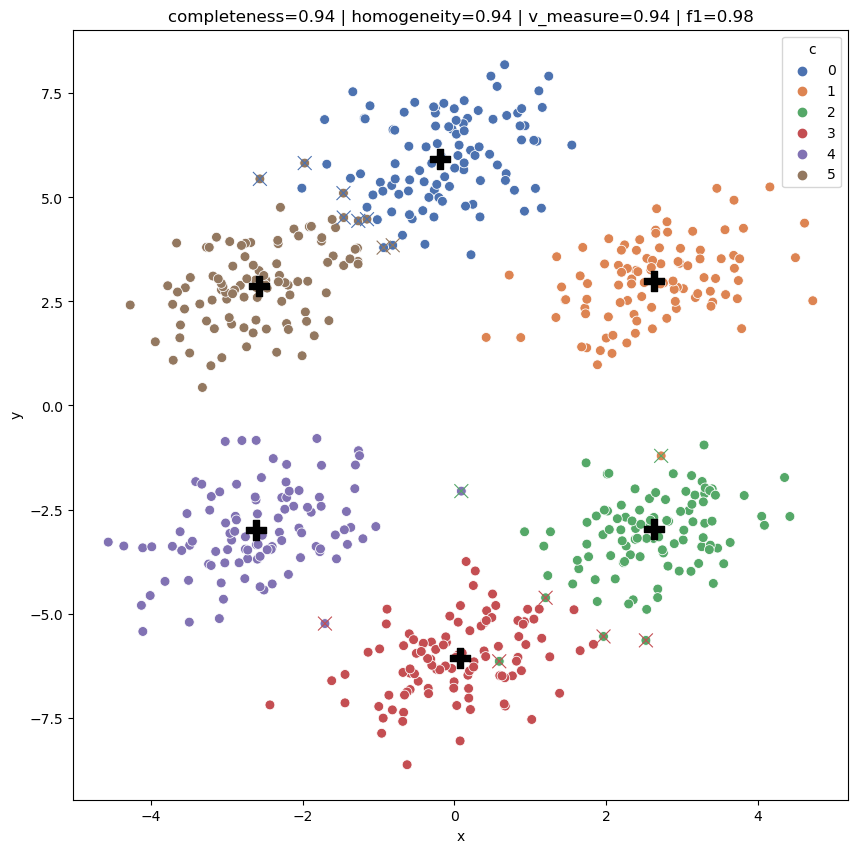

In [83]:
plot_clusters_2D(som,df)

In [4]:
som = SOM(input_dim=2, map_size=(3,3))
som.train(df[["x","y"]].values, epochs=200, neighborhood_function=gaussian_second_derivative, learning_rate=0.1, sigma=2, learning_rate_decay=100)

In [5]:
som.weights

array([[[-0.00168381, -0.07469648],
        [ 0.00021838, -0.07394218],
        [ 0.00144414, -0.07297642]],

       [[-0.00410841, -0.07727729],
        [-0.00231475, -0.07811655],
        [-0.00056248, -0.07537852]],

       [[-0.00468902, -0.07732348],
        [-0.0037838 , -0.07941167],
        [-0.0018306 , -0.0763787 ]]])

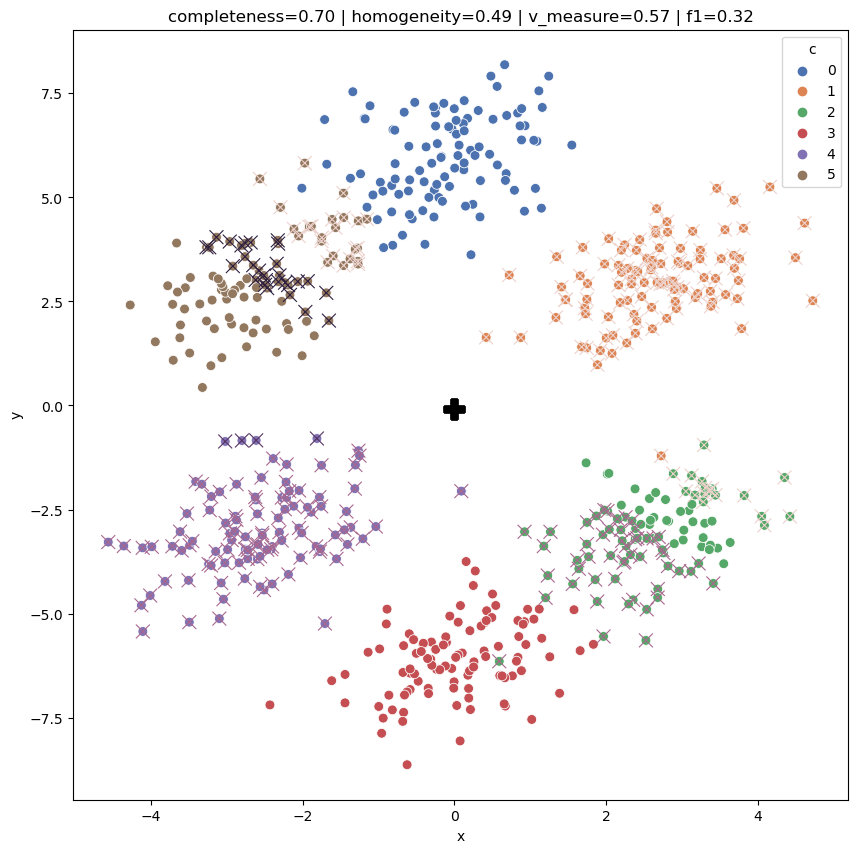

In [8]:
y_pred_relabeled, y_pred, f1, h_score,c_score,v_score = get_scores(som,df[['x','y']].values,df['c'])

errors = df["c"] != y_pred_relabeled
y_pred = pd.Series(y_pred)

palette = sns.color_palette("deep", as_cmap=True, n_colors=len(som.weights))
all_labels = sorted(set(df["c"]))
color_map = dict(zip(all_labels, palette))



fig = plt.figure(figsize=(10,10))
sns.scatterplot(data=df, x="x", y="y", hue=df["c"], palette=color_map, s=50)
sns.scatterplot(x=df.loc[errors,"x"],y= df.loc[errors,"y"], hue=y_pred_relabeled[errors], marker="x", s=100, legend=False)
plt.scatter(som.weights[:,:,0], som.weights[:,:,1], c="black", marker="P", s=200)
plt.title(f"completeness={c_score:.2f} | homogeneity={h_score:.2f} | v_measure={v_score:.2f} | f1={f1:.2f}")
plt.show()

In [9]:
df = pd.read_csv('data/cube.csv')

In [10]:
coefs_search(df[["x","y","z"]].values,df["c"],3,(4,2),100,neighborhood_functions,learning_rates,sigmas,decays=decays,allow_warnings=True)

v_score=0.8261344075857365 | function=gaussian, learning_rate=0.1, sigma=0.1, decay=10
v_score=0.8533882974349145 | function=gaussian, learning_rate=0.1, sigma=0.1, decay=100
v_score=0.9255084669150828 | function=gaussian, learning_rate=0.1, sigma=0.5, decay=10
v_score=0.8750378277176529 | function=gaussian, learning_rate=0.1, sigma=0.5, decay=100
v_score=0.6995308284584794 | function=gaussian, learning_rate=0.1, sigma=1, decay=10
v_score=0.6979636962751447 | function=gaussian, learning_rate=0.1, sigma=1, decay=100
v_score=0.7884220102647198 | function=gaussian, learning_rate=0.01, sigma=0.1, decay=10
v_score=0.7827765109367816 | function=gaussian, learning_rate=0.01, sigma=0.1, decay=100
v_score=0.7151799001466773 | function=gaussian, learning_rate=0.01, sigma=0.5, decay=10
v_score=0.8826049589833852 | function=gaussian, learning_rate=0.01, sigma=0.5, decay=100
v_score=0.6962317848603436 | function=gaussian, learning_rate=0.01, sigma=1, decay=10
v_score=0.699715198496835 | function=ga

In [11]:
coefs_search(df[["x","y","z"]].values,df["c"],3,(4,3),100,neighborhood_functions,learning_rates,sigmas,decays=decays,allow_warnings=True)

v_score=0.829800079828923 | function=gaussian, learning_rate=0.1, sigma=0.1, decay=10
v_score=0.8139697692646883 | function=gaussian, learning_rate=0.1, sigma=0.1, decay=100
v_score=0.856078903584405 | function=gaussian, learning_rate=0.1, sigma=0.5, decay=10
v_score=0.8463880315684381 | function=gaussian, learning_rate=0.1, sigma=0.5, decay=100
v_score=0.6994959716737736 | function=gaussian, learning_rate=0.1, sigma=1, decay=10
v_score=0.6563719469057725 | function=gaussian, learning_rate=0.1, sigma=1, decay=100
v_score=0.8045662344699269 | function=gaussian, learning_rate=0.01, sigma=0.1, decay=10
v_score=0.8011795206057616 | function=gaussian, learning_rate=0.01, sigma=0.1, decay=100
v_score=0.859741255939307 | function=gaussian, learning_rate=0.01, sigma=0.5, decay=10
v_score=0.8671383818701168 | function=gaussian, learning_rate=0.01, sigma=0.5, decay=100
v_score=0.6662398240918193 | function=gaussian, learning_rate=0.01, sigma=1, decay=10
v_score=0.701783423948206 | function=gauss

In [117]:
som = SOM(input_dim=3, map_size=(4,2))
som.train(df[["x","y","z"]].values, epochs=300, neighborhood_function=gaussian, learning_rate=0.01, sigma=0.5, learning_rate_decay=100)

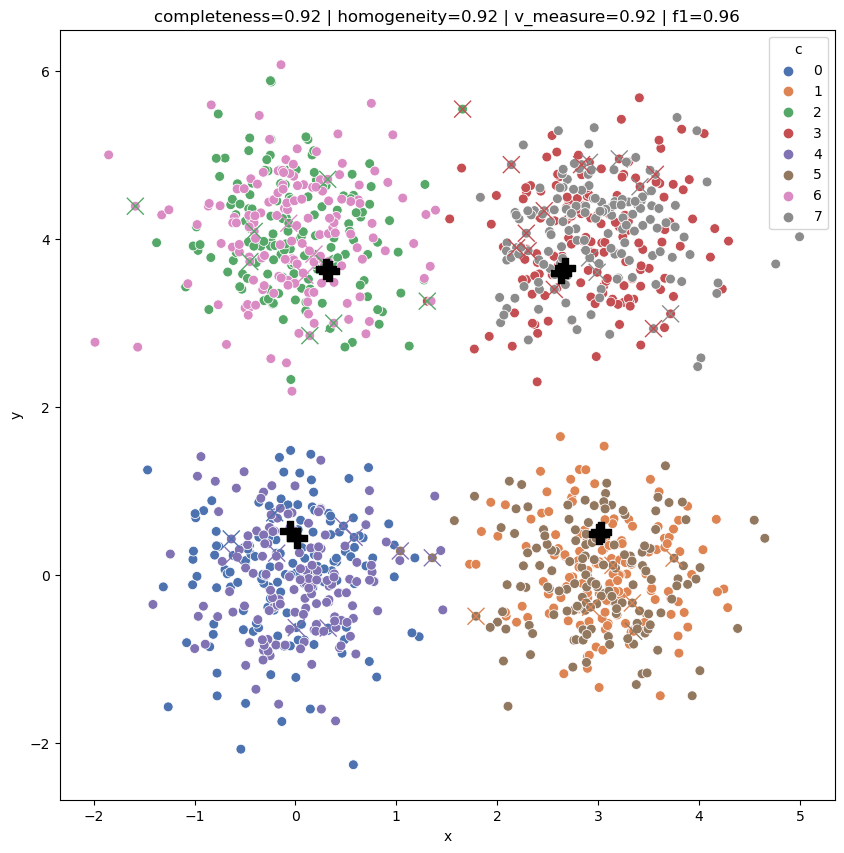

In [118]:
y_pred_relabeled, y_pred, f1, h_score,c_score,v_score = get_scores(som,df[["x","y","z"]].values,df["c"])

errors = df["c"] != y_pred_relabeled
y_pred = pd.Series(y_pred)

palette = sns.color_palette("deep", as_cmap=True, n_colors=len(som.weights))
all_labels = sorted(set(df["c"]))
color_map = dict(zip(all_labels, palette))


fig = plt.figure(figsize=(10,10))
sns.scatterplot(data=df, x="x", y="y", hue=df["c"], palette=color_map, s=50)
sns.scatterplot(x=df.loc[errors,"x"],y= df.loc[errors,"y"], hue=y_pred_relabeled[errors], palette=color_map, marker="x", s=150, legend=False)
plt.scatter(som.weights[:,:,0], som.weights[:,:,1], c="black", marker="P", s=200)
plt.title(f"completeness={c_score:.2f} | homogeneity={h_score:.2f} | v_measure={v_score:.2f} | f1={f1:.2f}")
plt.show()  

In [119]:
warnings.filterwarnings("ignore")
color_map_list = [(k/7, v) for k, v in color_map.items()]

neurons = go.Scatter3d(x=som.weights[:,:,0].flatten(),y=som.weights[:,:,1].flatten(),z=som.weights[:,:,2].flatten(),
                       mode='markers', marker=dict(size=10,color="black",symbol="cross"))
true_markers = go.Scatter3d(x=df["x"],y=df["y"],z=df["z"],mode='markers',marker=dict(size=3,color=df["c"],colorscale=color_map_list, opacity=0.9))
wrong_markers = go.Scatter3d(x=df.loc[errors,"x"],y= df.loc[errors,"y"], z=df.loc[errors,"z"], 
                   mode='markers',marker=dict(size=4,color=y_pred_relabeled[errors],colorscale=color_map_list,opacity=0.8,symbol='x'))



fig = go.Figure(data=[neurons,true_markers,wrong_markers])#,marker=dict(size=10,color="black"))])
fig.update_layout(width=900,height=700,margin=dict(l=0, r=0, b=0, t=10),
                  scene = dict(
                    xaxis=dict(showgrid=False, showbackground=False),
                    yaxis=dict(showgrid=False, showbackground=False),
                    zaxis=dict(showgrid=False, showbackground=False)
                ))

fig.show()
warnings.filterwarnings("default")


In [14]:
som = SOM(input_dim=3, map_size=(4,2))
som.train(df[["x","y","z"]].values, epochs=100, neighborhood_function=gaussian_second_derivative, learning_rate=0.01, sigma=0.1, learning_rate_decay=10)

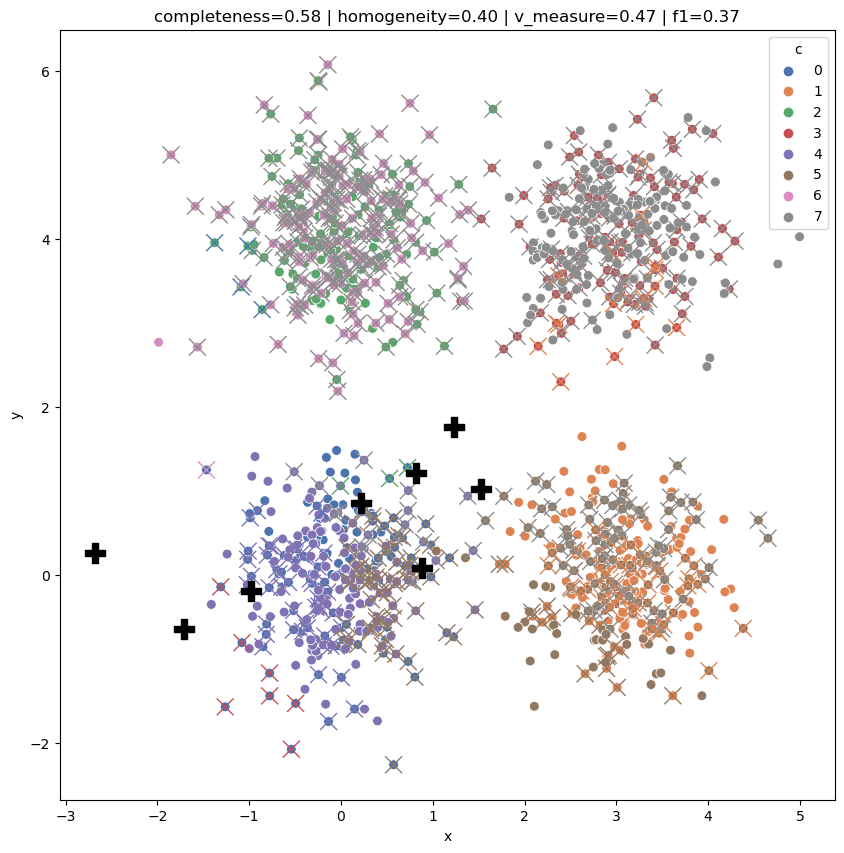

In [16]:
y_pred_relabeled, y_pred, f1, h_score,c_score,v_score = get_scores(som,df[["x","y","z"]].values,df["c"])

errors = df["c"] != y_pred_relabeled
y_pred = pd.Series(y_pred)

palette = sns.color_palette("deep", as_cmap=True, n_colors=len(som.weights))
all_labels = sorted(set(df["c"]))
color_map = dict(zip(all_labels, palette))

# Map the true and predicted labels to colors
true_colors = [color_map[label] for label in df["c"]]




fig = plt.figure(figsize=(10,10))
sns.scatterplot(data=df, x="x", y="y", hue=df["c"], palette=color_map, s=50)
sns.scatterplot(x=df.loc[errors,"x"],y= df.loc[errors,"y"], hue=y_pred_relabeled[errors], palette=color_map, marker="x", s=150, legend=False)
plt.scatter(som.weights[:,:,0], som.weights[:,:,1], c="black", marker="P", s=200)
plt.title(f"completeness={c_score:.2f} | homogeneity={h_score:.2f} | v_measure={v_score:.2f} | f1={f1:.2f}")
plt.show()  

In [17]:
color_map_list = [(k/7, v) for k, v in color_map.items()]

neurons = go.Scatter3d(x=som.weights[:,:,0].flatten(),y=som.weights[:,:,1].flatten(),z=som.weights[:,:,2].flatten(),
                       mode='markers', marker=dict(size=10,color="black",symbol="cross"))
true_markers = go.Scatter3d(x=df["x"],y=df["y"],z=df["z"],mode='markers',marker=dict(size=3,color=df["c"],colorscale=color_map_list, opacity=0.9))
wrong_markers = go.Scatter3d(x=df.loc[errors,"x"],y= df.loc[errors,"y"], z=df.loc[errors,"z"], 
                   mode='markers',marker=dict(size=4,color=y_pred_relabeled[errors],colorscale=color_map_list,opacity=0.8,symbol='x'))



fig = go.Figure(data=[neurons,true_markers,wrong_markers])#,marker=dict(size=10,color="black"))])
fig.update_layout(width=900,height=700,margin=dict(l=0, r=0, b=0, t=10),
                  scene = dict(
                    xaxis=dict(showgrid=False, showbackground=False),
                    yaxis=dict(showgrid=False, showbackground=False),
                    zaxis=dict(showgrid=False, showbackground=False)
                ))

fig.show()

/home/skowronski/miniconda3/envs/mio1/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



___
# Sześciokątna siatka 

In [1]:
from SOM import *

In [2]:
df = pd.read_csv("data/hexagon.csv")

In [3]:
som = SOM_HEX(2,(2,3))

In [16]:
som.train(df[["x","y"]].values,1000)

In [20]:
x = np.asarray(df.iloc[:, [0, 1]])
N, M = 2, 3
weights = np.random.uniform(np.min(x), np.max(x), size=(N * M, x.shape[1]))

In [27]:
df.iloc[:, [0, 1]]
x.shape[1]

2

In [21]:
weights

array([[-5.98836381, -0.26595064],
       [-0.64712705,  6.82889427],
       [-1.61235504,  2.79268442],
       [ 7.30327224, -5.15942298],
       [-5.49419402, -6.46654296],
       [ 7.95795491, -8.50227112]])

In [17]:
y_pred_relabeled, y_pred, f1, h_score,c_score,v_score = get_scores(som,df[["x","y"]].values,df["c"])

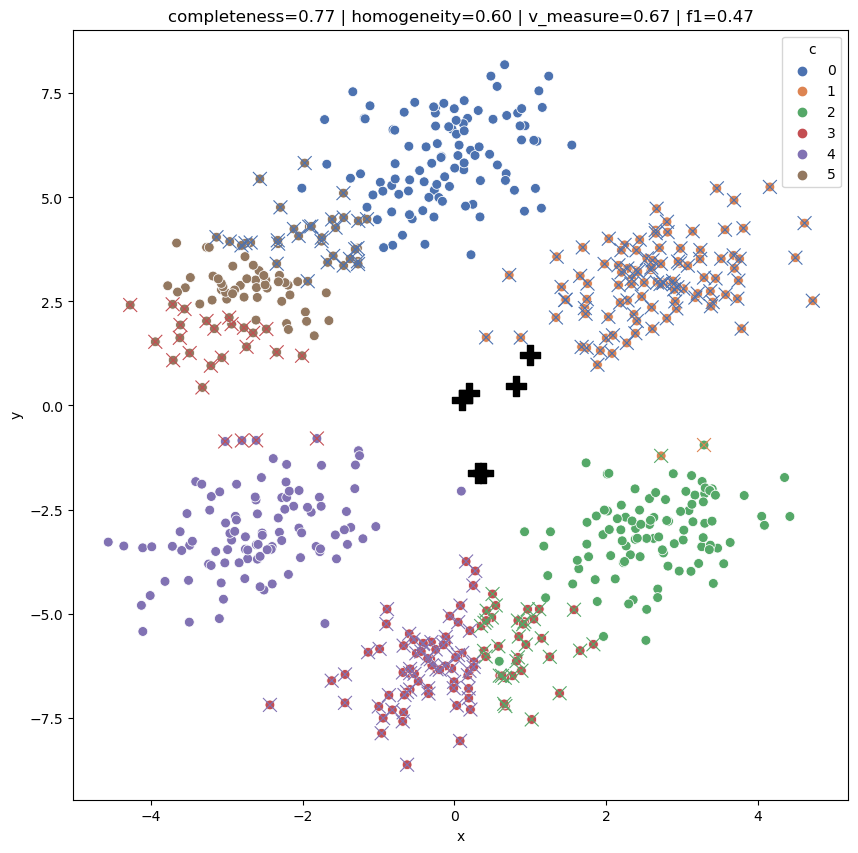

In [18]:
plot_clusters_2D(som,df)